# 今回の取り組み

- `correct_sequence_error`+`call_midsv`を変更したので、Stx2の結果を観察します
- なぜか大型欠失がinversionとして抽出されているので、その原因を調べます

## いつものセットアップ

In [49]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [50]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
import time

from DAJIN2.core import preprocess, classification, clustering, consensus, report


##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion-extract_qname_of_map_ont/",
    "mm10",
    True,
    30,
)


print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
print(f"validate inputs...")

print(f"check_files")
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)

TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)

UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
print(f"format inputs...")

SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

print(f"retrieve genomes...")

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)



processing single-stx2deletion-extract_qname_of_map_ont/...
validate inputs...
check_files
format inputs...
retrieve genomes...


In [4]:
flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    # ====================================================================
    # Export fasta files as single-FASTA format
    # ====================================================================
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    # ====================================================================
    # Mapping with mappy
    # ====================================================================
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    # ====================================================================
    # MIDSV conversion
    # ====================================================================
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    # ====================================================================
    # CSSPLITS Error Correction
    # ====================================================================
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    # ====================================================================
    # Convert any `N` as deletions other than consecutive `N` from both ends
    # ====================================================================
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    # ====================================================================
    # Cashe inputs (control)
    # ====================================================================
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


In [5]:
import midsv
results_sample = midsv.read_jsonl(Path(TEMPDIR, "result", f"{SAMPLE_NAME}.jsonl"))

In [6]:
for samp in results_sample:
    if "inversion" in samp["NAME"]:
        qname_inversion = samp["QNAME"]
        print(samp["QNAME"], samp["CSSPLIT"])
        break

007d3e8d-6ba1-4be1-8169-8d6e94ddee0b =G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,-T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,-A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,+C|=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,+A|=G,=T,*AG,*GA,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,+T|+G|+T|=G,=T,=G,=G,=T,=T,=G,-C,*TG,=T,=G,-A,-T,=G,=G,*AG,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,*GA,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,+A|=

In [7]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby, permutations
from pathlib import Path

import midsv

from DAJIN2.core.preprocess import mappy_align


def _extract_diff_loci(TEMPDIR: Path) -> defaultdict[dict]:
    """
    Extract differencial loci between alleles
        - The purpose is to lower match_score between very similar alleles such as point mutation.
    """
    fasta_alleles = list(Path(TEMPDIR, "fasta").iterdir())
    fasta_alleles = [f for f in fasta_alleles if f.suffix != ".fai"]
    mutation_alleles = defaultdict(dict)
    for pair in list(permutations(fasta_alleles, 2)):
        ref, query = pair
        ref_allele = ref.stem
        alignments = mappy_align.to_sam(ref, query, preset="splice")
        alignments = list(alignments)
        alignments = [a.split("\t") for a in alignments]
        alignments_midsv = midsv.transform(alignments, midsv=False, cssplit=True, qscore=False)[0]
        cssplits = alignments_midsv["CSSPLIT"].split(",")
        mutations = dict()
        for i, cs in enumerate(cssplits):
            if cs.startswith("="):
                continue
            mutations.update({i: cs})
        if len(mutations) < 10:
            mutation_alleles[ref_allele].update(mutations)
    return mutation_alleles


def _calc_match(CSSPLIT: str, mutations: dict) -> float:
    match_score = CSSPLIT.count("=")
    match_score -= CSSPLIT.count("+")  # insertion
    match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
    cssplit = CSSPLIT.split(",")
    for i, mut in mutations.items():
        if cssplit[i] == mut:
            match_score = 0
    return match_score / len(cssplit)


def classify_alleles(TEMPDIR: Path, SAMPLE_NAME: str) -> list[dict]:
    paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{SAMPLE_NAME}*.jsonl"))
    mutations = _extract_diff_loci(TEMPDIR)
    # Scoring
    score_of_each_alleles = []
    for path_midsv in paths_midsv:
        allele = path_midsv.stem.split("_")[-1]
        preset = path_midsv.stem.split("_")[-2]
        for dict_midsv in midsv.read_jsonl(path_midsv):
            score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
            dict_midsv.update({"SCORE": score})
            dict_midsv.update({"ALLELE": allele})
            dict_midsv.update({"PRESET": preset})
            score_of_each_alleles.append(dict_midsv)
    score_of_each_alleles.sort(key=lambda x: x["QNAME"])
    # Extract alleles with max scores
    possible_allele = []
    for _, group in groupby(score_of_each_alleles, key=lambda x: x["QNAME"]):
        max_score = -float("inf")
        for readinfo in group:
            if readinfo["SCORE"] > max_score:
                max_score = readinfo["SCORE"]
                max_read = readinfo
                del max_read["SCORE"]
        possible_allele.append(max_read)
    return possible_allele

paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{SAMPLE_NAME}*.jsonl"))
mutations = _extract_diff_loci(TEMPDIR)
# Scoring
score_of_each_alleles = []
for path_midsv in paths_midsv:
    allele = path_midsv.stem.split("_")[-1]
    preset = path_midsv.stem.split("_")[-2]
    for dict_midsv in midsv.read_jsonl(path_midsv):
        score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
        dict_midsv.update({"SCORE": score})
        dict_midsv.update({"ALLELE": allele})
        dict_midsv.update({"PRESET": preset})
        score_of_each_alleles.append(dict_midsv)
score_of_each_alleles.sort(key=lambda x: x["QNAME"])

In [9]:
for score in score_of_each_alleles:
    if score["QNAME"] == qname_inversion:
        print(score["ALLELE"], score["CSSPLIT"].count("N"), score["CSSPLIT"].count("-"), score["SCORE"])

deletion 1 1207 0.536571747627024
control 1 2509 0.40310977024831746
inversion 1 1429 0.6484103040148527


### inversionになっているリードを確認

In [415]:
results = midsv.read_jsonl("DAJINResults/.tempdir/single-stx2deletion-callmidsv/result/test_barcode25.jsonl")

In [418]:
for samp in results:
    if samp["ALLELE"] == "inversion":
        qname_inversion = samp["QNAME"]
        break

In [419]:
print(qname_inversion)

007d3e8d-6ba1-4be1-8169-8d6e94ddee0b


In [12]:
# 一旦リセット…
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)


def _replaceNtoD(cssplits_sample, sequence) -> list[list[str]]:
    cssplits_replaced = cssplits_sample.copy()
    for i, cssplits in enumerate(cssplits_sample):
        # extract right/left index of the end of sequential Ns
        left_idx_n = 0
        for cs in cssplits:
            if cs != "N":
                break
            left_idx_n += 1
        right_idx_n = 0
        for cs in cssplits[::-1]:
            if cs != "N":
                break
            right_idx_n += 1
        right_idx_n = len(cssplits) - right_idx_n - 1
        # replace sequential Ns within the sequence
        for j, (cs, seq) in enumerate(zip(cssplits, sequence)):
            if left_idx_n <= j <= right_idx_n and cs == "N":
                cssplits_replaced[i][j] = f"-{seq}"
    return cssplits_replaced

from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(indels_control[key])
        pred = clf.predict(indels_sample[key])
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci

# def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
#     anomaly_loci = dict()
#     for key, values in indels_sample.items():
#         clf = GaussianMixture(n_components = 2, random_state=0)
#         pred = clf.fit_predict(np.array(values).reshape(-1, 1))
#         # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
#         normal, abnormal = Counter(pred).keys()
#         if Counter(pred[:9]).most_common()[0][0] == abnormal:
#             normal, abnormal = abnormal, normal
#         loci = {i for i, p in enumerate(pred) if p == abnormal}
#         anomaly_loci.update({key: loci})
#     return anomaly_loci


# def _score_anomaly(count_sample: list[int | float]) -> list[float]:
#     x = np.array(count_sample)
#     average = np.mean(x)
#     sigma = np.std(x)
#     score = np.square((x - average) / sigma)
#     return score.tolist()


# def _extract_anomaly_loci_hotelling(score: list[float], threshold: float = 0.99) -> set[int]:
#     anomaly_loci = set()
#     thres = chi2.ppf(q=threshold, df=1)
#     for i, s in enumerate(score):
#         if s > thres:
#             anomaly_loci.add(i)
#     return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    # mutation_locus_single = _extract_anomaly_loci(indels_sample)
    # mutation_locus_single = {}
    # loci_sample = _extract_anomaly_loci(indels_sample)
    # loci_control = _extract_anomaly_loci(indels_control)
    # for key in ["ins", "del", "sub"]:
    #     mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    return _extract_anomaly_loci(x, y)
    # dists = _calc_distance(x, y)
    # loci_sample = _extract_anomaly_loci(dists)
    # mutation_locus_kmer = {}
    # for key in ["ins", "del", "sub"]:
    #     # score_sample = _score_anomaly(dists[key])
    #     mutation_locus_kmer.update({key: loci_sample[key]})
    # # Output
    # mutation_loci = {}
    # for key in ["ins", "del", "sub"]:
    #     mutation_loci.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    # return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


from pathlib import Path
from collections import defaultdict
import midsv
import re

def _get_qname_of_single_read(sam: list[list[str]]) -> set():
    count_qname = defaultdict(int)
    for alignment in sam:
        if alignment[0].startswith("@"):
            continue
        qname = alignment[0]
        count_qname[qname] += 1
    qname_of_single_read = set()
    for key, count in count_qname.items():
        if count == 1:
            qname_of_single_read.add(key)
    return qname_of_single_read


def _split_cigar(CIGAR:str) -> list[str]:
    cigar = re.split(r"([MIDNSH=X])", CIGAR)
    n = len(cigar)
    cigar_split = []
    for i, j in zip(range(0, n, 2), range(1, n, 2)):
        cigar_split.append(cigar[i] + cigar[j])
    return cigar_split

def _call_alignment_length(CIGAR: str) -> int:
    cigar_split = _split_cigar(CIGAR)
    alignment_length = 0
    for c in cigar_split:
        if re.search(r"[MDN=X]", c[-1]):
            alignment_length += int(c[:-1])
    return alignment_length

def _has_inversion_in_splice(CIGAR: str) -> bool:
    is_splice = False
    is_insertion = False
    for cigar in _split_cigar(CIGAR):
        if cigar.endswith("I"):
            is_insertion = True
            continue
        if is_insertion and cigar.endswith("N"):
            is_splice = True
            break
        else:
            is_insertion = False
    return is_splice


def _extract_qname_of_map_ont(sam_ont: list[list[str]], sam_splice: list[list[str]], qname_of_single_read: set) -> set():
    """Extract qname of reads from `map-ont` when:
        - single read
        - long alignment length
        - no inversion signal in `splice` alignment (insertion + deletion)
    """
    dict_sam_ont = {s[0]: s for s in sam_ont if s[0] in qname_of_single_read}
    dict_sam_splice = {s[0]: s for s in sam_splice if s[0] in qname_of_single_read}
    qname_of_map_ont = set()
    for qname in qname_of_single_read:
        if not qname in dict_sam_splice:
            continue
        alignment_ont = dict_sam_ont[qname]
        alignment_splice = dict_sam_splice[qname]
        if _has_inversion_in_splice(alignment_splice[5]):
            continue
        alignment_length_ont = _call_alignment_length(alignment_ont[5])
        alignment_length_splice = _call_alignment_length(alignment_splice[5])
        if alignment_length_ont >= alignment_length_splice:
            qname_of_map_ont.add(qname)
    return qname_of_map_ont


def _extract_sam(sam: list[list[str]], qname_of_map_ont: set, preset:str="map-ont") -> list[list[str]]:
    sam_extracted = []
    for alignment in sam:
        if alignment[0].startswith("@"):
            sam_extracted.append(alignment)
        if preset == "map-ont":
            if alignment[0] in qname_of_map_ont:
                sam_extracted.append(alignment)
        else:
            if alignment[0] not in qname_of_map_ont:
                sam_extracted.append(alignment)
    return sam_extracted


def _midsv_transform(sam: list[list[str]]) -> list[list[str]]:
    num_header = 0
    for s in sam:
        if s[0].startswith("@"):
            num_header += 1
        else:
            break
    if len(sam) == num_header:
        return []
    return midsv.transform(sam, midsv=False, cssplit=True, qscore=False)


def call_midsv(TEMPDIR, SAMPLE_NAME, allele) -> None:
    sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
    sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
    qname_of_single_read = _get_qname_of_single_read(sam_ont)
    qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
    sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
    sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
    midsv_of_single_read = _midsv_transform(sam_of_map_ont)
    midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
    midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
    midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

# def call_midsv(TEMPDIR, path_sam):
#     sam = midsv.read_sam(path_sam)
#     midsv_jsonl = midsv.transform(sam, midsv=False, cssplit=True, qscore=True)
#     output_jsonl = Path(TEMPDIR, "midsv", f"{path_sam.stem}.jsonl")
#     midsv.write_jsonl(midsv_jsonl, output_jsonl)


In [15]:
for allele, sequence in FASTA_ALLELES.items():
    sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
    sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
    qname_of_single_read = _get_qname_of_single_read(sam_ont)
    qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
    sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
    sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
    midsv_of_single_read = _midsv_transform(sam_of_map_ont)
    midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
    midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
    print("Initial Score =================")
    for samp in midsv_sample:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), samp["CSSPLIT"].count("-"),match_score)
    print("REPLACE N to D =================")
    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
    cssplits_replaced = _replaceNtoD(cssplits_sample, sequence)
    midsv_cssplits = [",".join(cs) for cs in cssplits_replaced]
    for i, cssplits in enumerate(midsv_cssplits):
        midsv_sample[i]["CSSPLIT"] = cssplits
    for samp in midsv_sample:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), samp["CSSPLIT"].count("-"),match_score)
    print("CORRECT SEQUENCE ERROR =================")
    midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
    cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    # Extract mutation loci
    mutation_loci = _extract(cssplits_sample, cssplits_control)
    # Correct sequence errors
    cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
    cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
    cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
    cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
    # Replace CSSPLIT
    cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
    cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
    for i, cssplits in enumerate(cssplits_sample_corrected):
        midsv_sample[i]["CSSPLIT"] = cssplits
    for i, cssplits in enumerate(cssplits_control_corrected):
        midsv_control[i]["CSSPLIT"] = cssplits
    for samp in midsv_sample:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), samp["CSSPLIT"].count("-"),match_score)


Initial Score =================
deletion 1749 60 0.4620323841429369
REPLACE N to D =================
deletion 0 1809 0.4620323841429369
CORRECT SEQUENCE ERROR =================
deletion 1 1207 0.536571747627024
Initial Score =================
control 2476 60 0.38407983290786724
REPLACE N to D =================
control 0 2536 0.38407983290786724
CORRECT SEQUENCE ERROR =================
control 1 2509 0.40310977024831746
Initial Score =================
inversion 2476 60 0.38407983290786724
REPLACE N to D =================
inversion 0 2536 0.38407983290786724
CORRECT SEQUENCE ERROR =================
inversion 1 1429 0.6484103040148527


- inversionのアレルがなぜかめちゃくちゃ補正されている！
- `midsv.transform`で`splice`のときの挿入と欠失が直に反映されてしまっている（inversionとして小文字になっていない…）

In [18]:
TEMPDIR

PosixPath('DAJINResults/.tempdir/single-stx2deletion-extract_qname_of_map_ont')

In [19]:
allele = "inversion"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))

In [20]:
count = defaultdict(int)
for cont in midsv_control:
    count[cont["CSSPLIT"].split(",")[2500]] += 1

print(count)
print(cont["CSSPLIT"])

defaultdict(<class 'int'>, {'-C': 881, 'N': 104, '=C': 2, '=c': 20, '-c': 1})
=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,+G|+A|=G,=A,=A,=G,+A|*GA,*CA,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,*GA,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,-C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,+A|+A|+A|*GA,=C,-T,=T,=A,=G,+C|=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,+C|=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,-A,=G,=G,=G,=G,=T,=A,=G,+C|=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,+G|+A|=G,=A,=G,=G,=T,+A|+A|+G|=G,=A,=G,=T,=G,=A,=G,=T,+C|=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,*GA,=C,=C,*GA,=C,+T|+T|+T|+T|=A,=T,=A,+C|=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=

In [21]:
count = defaultdict(int)
for cont in midsv_sample:
    count[cont["CSSPLIT"].split(",")[2500]] += 1

print(count)
print(cont["CSSPLIT"])

defaultdict(<class 'int'>, {'-C': 1495, 'N': 2, '=C': 3})
=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,-C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,*CT,*AT,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,+T|=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=

In [22]:
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
midsv_sample = midsv_of_single_read + midsv_of_multiple_reads


In [24]:
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
print(len(sam_ont))
print(len(sam_splice))
print(len(qname_of_map_ont))

2788
1077
100


In [25]:
def _extract_qname_of_map_ont(sam_ont: list[list[str]], sam_splice: list[list[str]], qname_of_single_read: set) -> set():
    """Extract qname of reads from `map-ont` when:
        - single read
        - long alignment length
        - no inversion signal in `splice` alignment (insertion + deletion)
    """
    dict_sam_ont = {s[0]: s for s in sam_ont if s[0] in qname_of_single_read}
    dict_sam_splice = {s[0]: s for s in sam_splice if s[0] in qname_of_single_read}
    qname_of_map_ont = set()
    for qname in qname_of_single_read:
        if not qname in dict_sam_splice:
            continue
        alignment_ont = dict_sam_ont[qname]
        alignment_splice = dict_sam_splice[qname]
        if _has_inversion_in_splice(alignment_splice[5]):
            qname_of_map_ont.add(qname)
            continue
        alignment_length_ont = _call_alignment_length(alignment_ont[5])
        alignment_length_splice = _call_alignment_length(alignment_splice[5])
        if alignment_length_ont >= alignment_length_splice:
            qname_of_map_ont.add(qname)
    return qname_of_map_ont



In [28]:
allele = "inversion"
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
print(len(sam_ont))
print(len(sam_splice))
print(len(qname_of_single_read))
print(len(qname_of_map_ont))

2788
1077
137
110


In [33]:
alignments_ont = [s for s in sam_ont if not s[0].startswith("@")]
alignments_ont.sort(key=lambda x: x[0])
print(alignments_ont[0])

['0029800d-d910-4ea5-b5d6-b7b332c5abf5', '16', 'inversion', '4', '60', '423S30M1I21M1D32M1I2M2I61M1D97M1D1M1D34M3D9M3D38M1D20M1D38M7D42M1I31M1D66M1I64M1I1M2D3M1D40M2D29M1I13M1D47M2D9M4D22M1D5M1I68M2D19M1D30M1D171M1D13M1D99M2D27M1D14M2D14M2D7M2I11M1I6M2D26M1D75M1D93M3D5M3D112M1D2M2D31M1I3M1I16M2I11M1I28M1I15M3D34M1D11M1I106M1I5M2D17M1D58M1I7M2D14M1D17M1D20M2294S', '*', '0', '0', 'GTTACGTATTGCTTCAGTGAGGATCTACTGACCCATTTCTGTTGGTGCTGATATTGTACTCCAGGGTGTCTCATAGTGTTTGAAGATAGAGCGACAGGCAAGTTCAGTGAGGATCTACTGACCCATTTCTGCTGGTGCCGATATTGCGCCCAGGGTGTCTCATAGTGTGTGAAGATAGAGCGACAGGCAAGTTCAGTGAGGATCTACTGACCCATTTCTGTTGGTGCTGATATTGCGCTCCAGGGTGTCTCATAGTGTTTGGAAGATAGAGCGACAGGCAAGTTCAGTGAGGATCTACTTCGACCCATTTCTGTTGGTGCTGATATTGCGCTCCAGGGTGTCTCATAGTGTTTGAAGATAGAGCGATTGGTAAAATTCAGTGAGATCTACTCTCGACCCATTTCGTTGGTGCTGATATTGCGCCCAGGGTGTCTCATAGTGTTTGAAGGCTCCTTAAATTGCCCAGTGTTCAGCTGGGAAAGACTACCAGCTAGGCAGGATCCAGAGTGATGTAATGAGTGTGCCCCATGGGACTCTGGCTTAGCCGCAGCTCTACCCTAAGCCCACAGTTGAGGGTAGTGGATCTTGTGTTTGAGGACATTAACAACAGGCTGATTG

In [42]:

def _extract_qname_of_map_ont(sam_ont: list[list[str]], sam_splice: list[list[str]]) -> set():
    """Extract qname of reads from `map-ont` when:
        - no inversion signal in `splice` alignment (insertion + deletion)
        - single read
        - long alignment length
    """
    alignments_ont = [s for s in sam_ont if not s[0].startswith("@")]
    alignments_ont.sort(key=lambda x: x[0])
    dict_alignments_splice = {s[0]: s for s in sam_splice if not s[0].startswith("@")}
    qname_of_map_ont = set()
    for qname_ont, group in groupby(alignments_ont, key=lambda x: x[0]):
        alignment_ont = list(group)
        if not qname_ont in dict_alignments_splice:
            qname_of_map_ont.add(qname_ont)
            continue
        alignment_splice = dict_alignments_splice[qname_ont]
        if _has_inversion_in_splice(alignment_splice[5]):
            qname_of_map_ont.add(qname_ont)
            continue
        if len(alignment_ont) != 1:
            continue
        alignment_ont = alignment_ont[0]
        alignment_length_ont = _call_alignment_length(alignment_ont[5])
        alignment_length_splice = _call_alignment_length(alignment_splice[5])
        if alignment_length_ont >= alignment_length_splice:
            qname_of_map_ont.add(qname_ont)
    return qname_of_map_ont

In [43]:
allele = "inversion"
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{CONTROL_NAME}_splice_{allele}.sam")
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice)
print(len(sam_ont))
print(len(sam_splice))
print(len(qname_of_map_ont))

2788
1077
877


In [53]:
%%bash

rm -rf DAJINResults/single-stx2deletion-extract_qname_of_map_ont
rm -rf DAJINResults/.tempdir/single-stx2deletion-extract_qname_of_map_ont

time DAJIN2 \
    --name single-stx2deletion-extract_qname_of_map_ont \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-extract_qname_of_map_ont to see the report.

real	1m55.999s
user	2m38.667s
sys	2m17.160s


- `_extract_qname_of_map_ont`のバグを取ることで、`inversion`リードが消えました🎉
    1. まず、`splice`にないQNAMEだったら`map-ont`をつかう
    2. 次に、`splice`にinversionマークが見られたら`map-ont`を使う
    3. 次に、`map-ont`が2つ以上のリードに分かれていたら`splice`を使う
    4. 最後に、`map-ont`のアラインメント長が`splice`よりも大きかったら`map-ont`を使う
    といった形にしました。
-  3番目だけ`splice`を使う指定なのはちょっと汚いですが、実際に動いているので良しとします

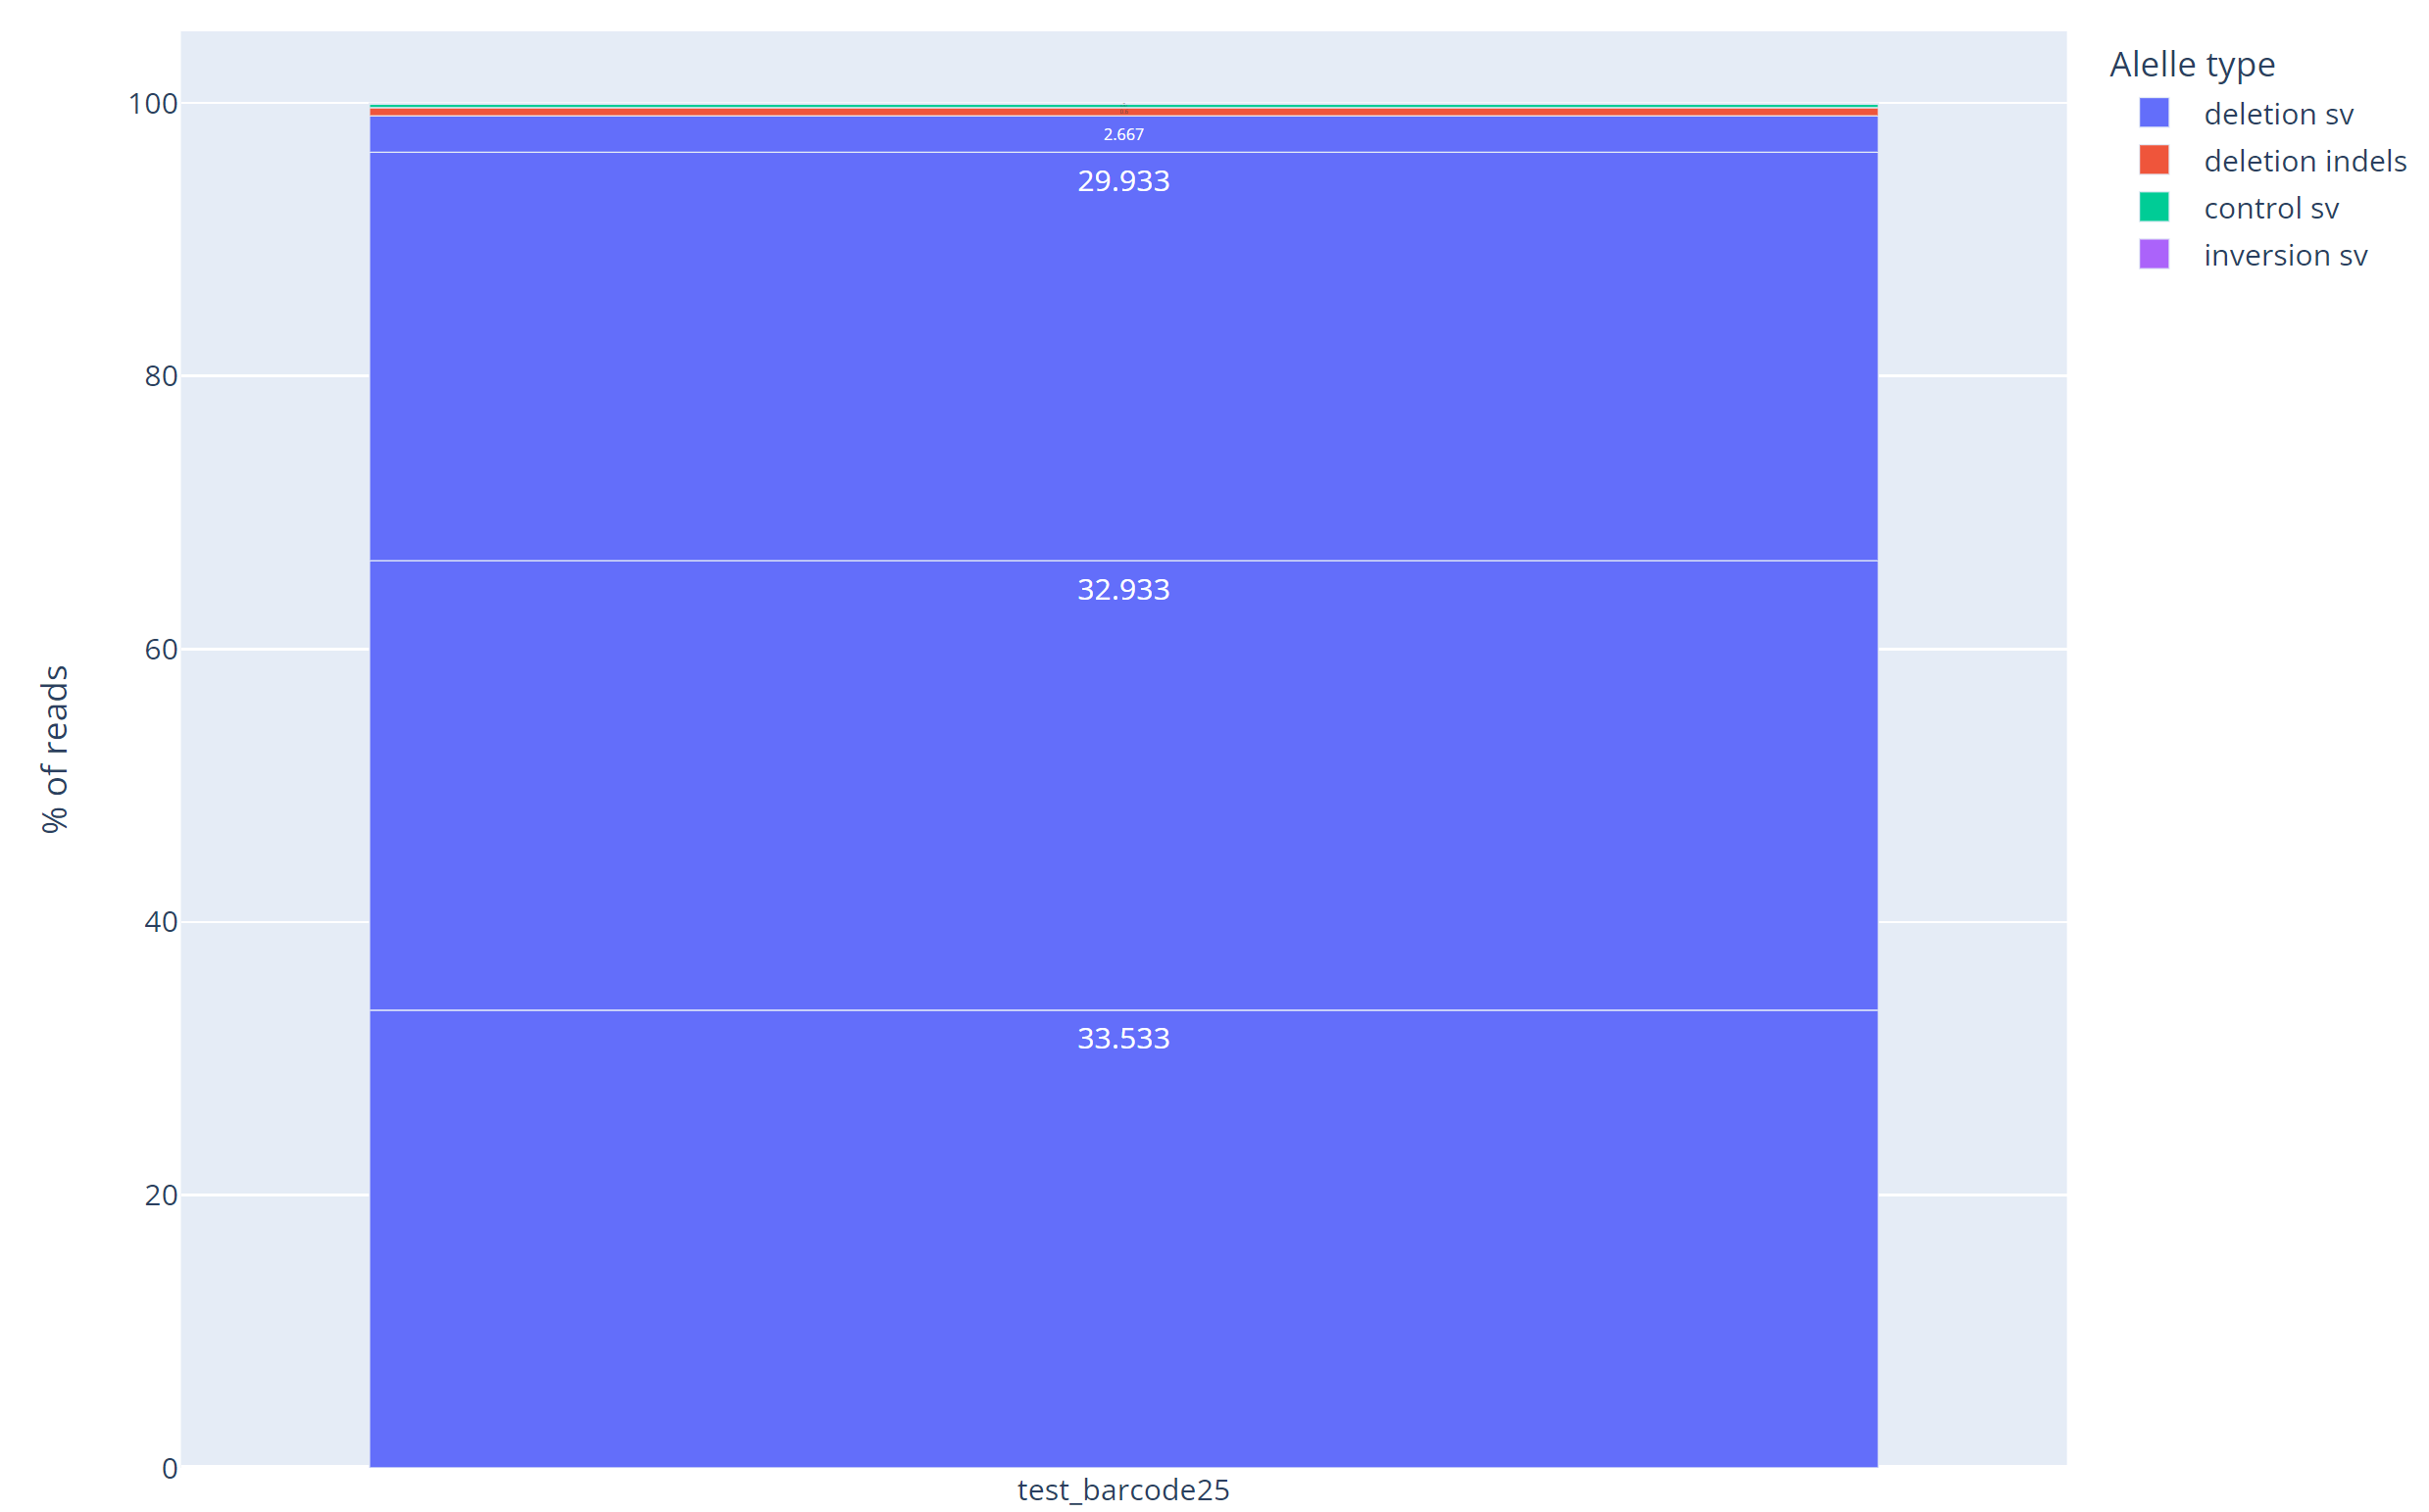

- あとは、例のごとくホモポリマー領域に対する補正が甘いので対応します
    - `correct_repetitive_sequence`を復活させても良い気がします

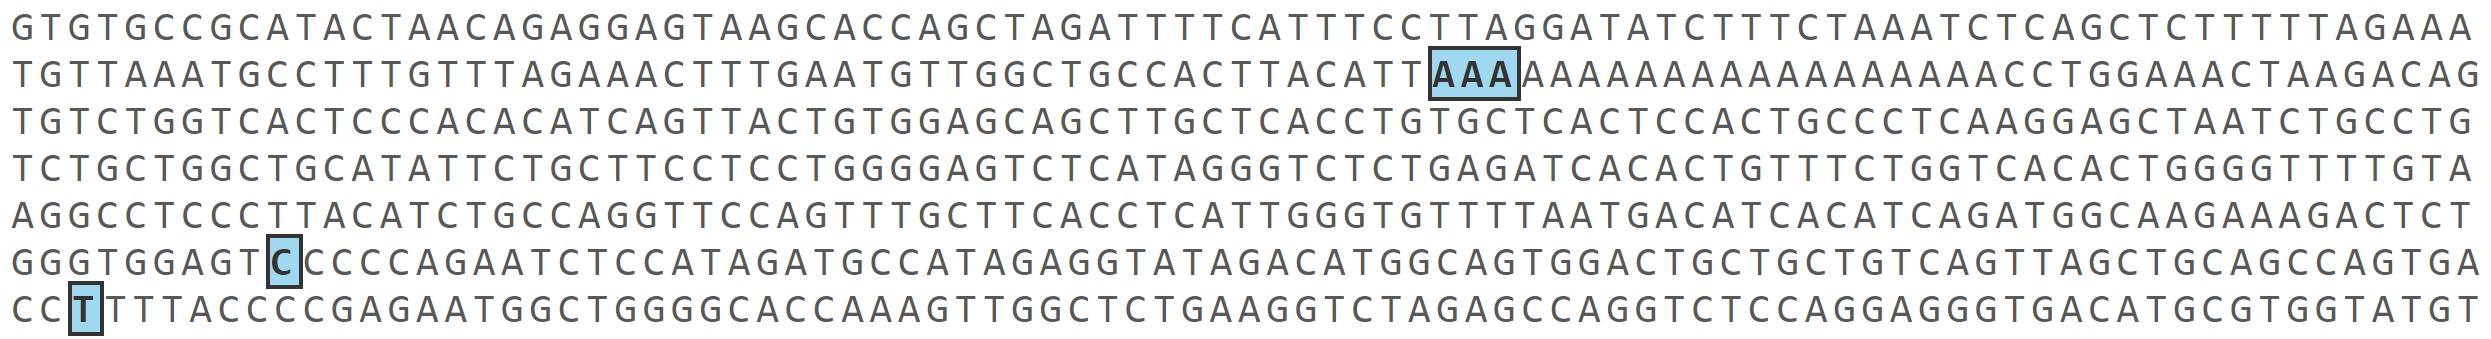

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `_extract_qname_of_map_ont`のバグを取ることで、`inversion`リードが消えました🎉
    1. まず、`splice`にないQNAMEだったら`map-ont`をつかう
    2. 次に、`splice`にinversionマークが見られたら`map-ont`を使う
    3. 次に、`map-ont`が2つ以上のリードに分かれていたら`splice`を使う
    4. 最後に、`map-ont`のアラインメント長が`splice`よりも大きかったら`map-ont`を使う
    といった形にしました。
-  3番目だけ`splice`を使う指定なのはちょっと汚いですが、実際に動いているので良しとします


# 次に取り組むこと

- ホモポリマー領域の欠失について精度が低いので対応する
- 現状のアルゴリズムの動作確認をTyr, Stx2, Floxで行う
- mutation_lociをpreprocessで使用したものに変更する

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする